<a href="https://colab.research.google.com/github/OleksiiLozovyi/goit-ds-hw-11/blob/main/GoIT_HW_8_new.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Створення нейронної мережі

У цьому завданні ми створимо повнозв'язну нейронну мережу, використовуючи при цьому низькорівневі механізми tensorflow.

Архітектура нейромережі представлена на наступному малюнку. Як бачиш, у ній є один вхідний шар, два приховані, а також вихідний шар. В якості активаційної функції у прихованих шарах буде використовуватись сигмоїда. На вихідному шарі ми використовуємо softmax.

Частина коду зі створення мережі вже написана, тобі потрібно заповнити пропуски у вказаних місцях.

## Архітектура нейронної мережі

<img src="http://cs231n.github.io/assets/nn1/neural_net2.jpeg" alt="nn" style="width: 400px;"/>


## Про датасет MNIST

Дану нейромережу ми будемо вивчати на датасеті MNIST. Цей датасет являє собою велику кількість зображень рукописних цифр розміром $28 \times 28$ пікселів. Кожен піксель приймає значення від 0 до 255.

Як і раніше, датасет буде розділений на навчальну та тестову вибірки. При цьому ми виконаємо нормалізацію всіх зображень, щоб значення пікселів знаходилось у проміжку від 0 до 1, розділивши яскравість кожного пікселя на 255.

Окрім того, архітектура нейронної мережі очікує на вхід вектор. У нашому ж випадку кожен об'єкт вибірки являє собою матрицю. Що ж робити? У цьому завданні ми "розтягнемо" матрицю $28 \times 28$, отримавши при цьому вектор, що складається з 784 елементів.

![MNIST Dataset](https://www.researchgate.net/profile/Steven-Young-5/publication/306056875/figure/fig1/AS:393921575309346@1470929630835/Example-images-from-the-MNIST-dataset.png)

Більше інформації про датасет можна знайти [тут](http://yann.lecun.com/exdb/mnist/).

In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import keras as K
import seaborn as sns
from sklearn.metrics import confusion_matrix

In [2]:
num_classes = 10 # загальна кількість класів, у нашому випадку це цифри від 0 до 9
num_features = 784 # кількість атрибутів вхідного вектора 28 * 28 = 784

learning_rate = 0.001 # швидкість навчання нейронної мережі
training_steps = 3000 # максимальне число епох
batch_size = 256 # перераховувати ваги мережі ми будемо не на всій вибірці, а на її випадковій підмножині з batch_size елементів
display_step = 100 # кожні 100 ітерацій ми будемо показувати поточне значення функції втрат і точності

n_hidden_1 = 128 # кількість нейронів 1-го шару
n_hidden_2 = 256 # кількість нейронів 2-го шару

In [3]:
# from tensorflow.keras.datasets import mnist
from keras.datasets import mnist

# Завантажуємо датасет
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Перетворюємо цілочисельні пікселі на тип float32
x_train, x_test = np.array(x_train, np.float32), np.array(x_test, np.float32)

# Перетворюємо матриці розміром 28x28 пікселів у вектор з 784 елементів
x_train, x_test = x_train.reshape([-1, num_features]), x_test.reshape([-1, num_features])

# Нормалізуємо значення пікселів
x_train, x_test = x_train / 255., x_test / 255.

# Перемішаємо тренувальні дані
train_data = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_data = train_data.repeat().shuffle(5000).batch(batch_size).prefetch(1)

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [4]:
# Створимо нейронну мережу

class DenseLayer(tf.Module):
    def __init__(self, in_features, out_features, name=None):
        super().__init__(name=name)
        self.w = tf.Variable(
            tf.random.normal([in_features, out_features]), name="w"
        )
        self.b = tf.Variable(tf.zeros([out_features]), name="b")

    def __call__(self, x, activation=0):
        y = tf.matmul(x, self.w) + self.b
        if activation != 0:
            return tf.nn.softmax(y)
        else:
            return tf.nn.sigmoid(y)

class NN(tf.Module):
    def __init__(self, name=None):
        super().__init__(name=name)
        self.layer1 = DenseLayer(num_features, n_hidden_1)

        self.layer2 = DenseLayer(n_hidden_1, n_hidden_2)

        self.output_layer = DenseLayer(n_hidden_2, num_classes)

    def __call__(self, x):
        x = self.layer1(x, activation=0)

        x = self.layer2(x, activation=0)

        x = self.output_layer(x, activation=1)

        return x

In [8]:
# В якості функції помилки в даному випадку зручно взяти крос-ентропію
def cross_entropy(y_pred, y_true):
    # Закодувати label в one hot vector
    y_true = tf.one_hot(y_true, depth=num_classes)

    y_pred = tf.clip_by_value(y_pred, 1e-9, 1.)

    return tf.reduce_mean(-tf.reduce_sum(y_true * tf.math.log(y_pred)))

def accuracy(y_pred, y_true):
    y_pred_classes = tf.argmax(y_pred, axis=1)

    correct_predictions = tf.equal(y_pred_classes, tf.cast(y_true, tf.int64))

    return tf.reduce_mean(tf.cast(correct_predictions, tf.float32))

In [9]:
# Створимо екземпляр нейронної мережі
neural_net = NN(name="mnist")

# Функція навчання нейромережі
def train(neural_net, input_x, output_y):
  # Для налаштування вагів мережі будемо використовувати стохастичний градієнтний спуск
  optimizer = tf.optimizers.SGD(learning_rate)

  # Активація автоматичного диференціювання
  with tf.GradientTape() as g:
    pred = neural_net(input_x)
    loss = cross_entropy(pred, output_y)

    trainable_params = [neural_net.layer1.w, neural_net.layer1.b,
                        neural_net.layer2.w, neural_net.layer2.b,
                        neural_net.output_layer.w, neural_net.output_layer.b]

    gradients = g.gradient(loss, trainable_params)

    optimizer.apply_gradients(zip(gradients, trainable_params))

    return loss

In [10]:
# Тренування мережі

loss_history = []  # кожні display_step кроків зберігай в цьому списку поточну помилку нейромережі
accuracy_history = [] # кожні display_step кроків зберігай в цьому списку поточну точність нейромережі

# У цьому циклі ми будемо проводити навчання нейронної мережі
# із тренувального датасета train_data вилучи випадкову підмножину, на якій
# відбудеться тренування. Використовуй метод take, доступний для тренувального датасета.
for step, (batch_x, batch_y) in enumerate(train_data.take(training_steps), 1):
    # Оновлюємо ваги нейронної мережі
    # Місце для вашого коду

    if step % display_step == 0:
        pred = neural_net(batch_x)

        loss_value = cross_entropy(pred, batch_y)
        acc_value = accuracy(pred, batch_y)

        loss_history.append(loss_value.numpy())
        accuracy_history.append(acc_value.numpy())

        print(f"Step: {step}, Loss: {loss_value.numpy():.4f}, Accuracy: {acc_value.numpy():.4f}")


Step: 100, Loss: 3829.6177, Accuracy: 0.1016
Step: 200, Loss: 3917.0471, Accuracy: 0.0586
Step: 300, Loss: 3700.5288, Accuracy: 0.0859
Step: 400, Loss: 3818.4126, Accuracy: 0.1133
Step: 500, Loss: 4090.8699, Accuracy: 0.0625
Step: 600, Loss: 3868.2744, Accuracy: 0.1133
Step: 700, Loss: 3845.6851, Accuracy: 0.0859
Step: 800, Loss: 3822.3218, Accuracy: 0.0977
Step: 900, Loss: 3702.5396, Accuracy: 0.1055
Step: 1000, Loss: 3934.5117, Accuracy: 0.0742
Step: 1100, Loss: 3793.4011, Accuracy: 0.0938
Step: 1200, Loss: 3928.2007, Accuracy: 0.0859
Step: 1300, Loss: 3753.2930, Accuracy: 0.1016
Step: 1400, Loss: 3942.7896, Accuracy: 0.0781
Step: 1500, Loss: 4061.1218, Accuracy: 0.0703
Step: 1600, Loss: 3808.0901, Accuracy: 0.0859
Step: 1700, Loss: 3784.7114, Accuracy: 0.0977
Step: 1800, Loss: 3837.5234, Accuracy: 0.0625
Step: 1900, Loss: 3946.3586, Accuracy: 0.0664
Step: 2000, Loss: 3712.9170, Accuracy: 0.1289
Step: 2100, Loss: 3978.1772, Accuracy: 0.0703
Step: 2200, Loss: 3852.9211, Accuracy: 0.09

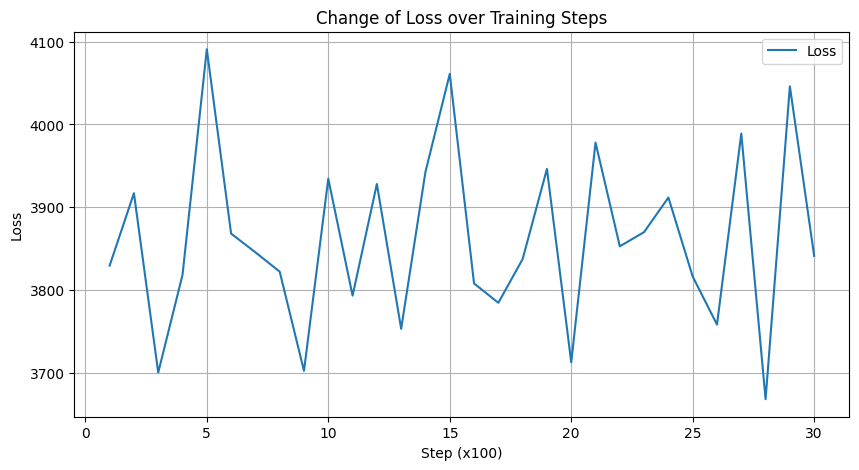

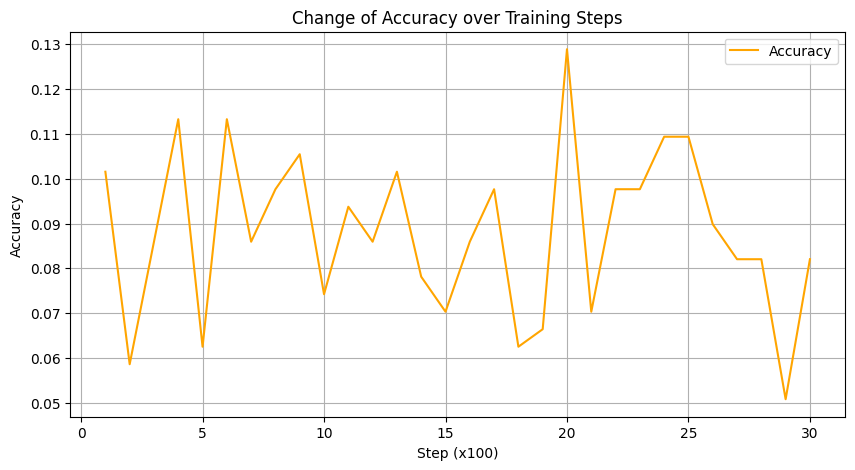

In [11]:
# Виведіть графіки залежності зміни точності і втрат від кроку
# Якщо все зроблено правильно, то точність повинна зростати, а втрати зменшуватись

import matplotlib.pyplot as plt

# Виведіть графік функції втрат
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(loss_history) + 1), loss_history, label="Loss")
plt.xlabel("Step (x100)")  # Кількість кроків
plt.ylabel("Loss")
plt.title("Change of Loss over Training Steps")
plt.legend()
plt.grid(True)
plt.show()

# Виведіть графік точності
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(accuracy_history) + 1), accuracy_history, label="Accuracy", color="orange")
plt.xlabel("Step (x100)")  # Кількість кроків
plt.ylabel("Accuracy")
plt.title("Change of Accuracy over Training Steps")
plt.legend()
plt.grid(True)
plt.show()

In [12]:
def evaluate_model(neural_net, x_test, y_test):
    y_pred = neural_net(x_test)

    acc = accuracy(y_pred, y_test)
    return acc

test_accuracy = evaluate_model(neural_net, x_test, y_test)

print(f"Test Accuracy: {test_accuracy.numpy():.4f}")

Test Accuracy: 0.0871


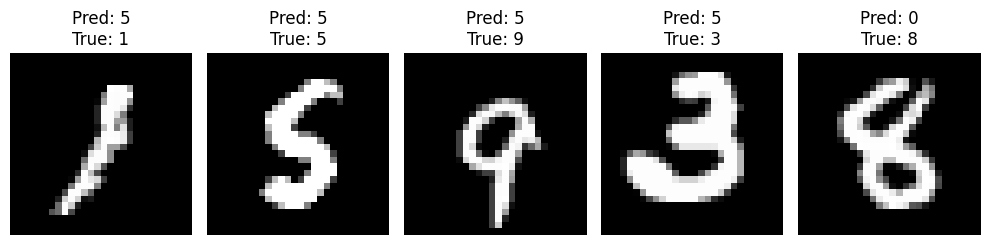

Out of 5 images:
  Correct Predictions: 1
  Wrong Predictions: 4
  Accuracy: 0.20


In [15]:
# Протестуйте навчену нейромережу на 10 зображеннях. З тестової вибірки візьміть 5
# випадкових зображень і передайте їх у нейронну мережу.
# Виведіть зображення та випишіть  поруч відповідь нейромережі.
# Зробіть висновок про те, чи помиляється твоя нейронна мережа, і якщо так, то як часто?

def test_random_images(neural_net, x_test, y_test, num_images=5):
    # Вибираємо випадкові індекси
    indices = np.random.choice(len(x_test), num_images, replace=False)
    selected_images = x_test[indices]
    true_labels = y_test[indices]

    predictions = neural_net(selected_images)
    predicted_classes = tf.argmax(predictions, axis=1).numpy()

    plt.figure(figsize=(10, 5))
    for i in range(num_images):
        plt.subplot(1, num_images, i + 1)
        plt.imshow(selected_images[i].reshape(28, 28), cmap='gray')
        plt.title(f"Pred: {predicted_classes[i]}\nTrue: {true_labels[i]}")
        plt.axis('off')
    plt.tight_layout()
    plt.show()

    num_correct = np.sum(predicted_classes == true_labels)
    num_wrong = num_images - num_correct
    print(f"Out of {num_images} images:")
    print(f"  Correct Predictions: {num_correct}")
    print(f"  Wrong Predictions: {num_wrong}")
    print(f"  Accuracy: {num_correct / num_images:.2f}")

test_random_images(neural_net, x_test, y_test, num_images=5)

